In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

df = pd.read_csv(".//csv//Student Depression Dataset.csv")
print(df.columns)

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


In [3]:
print(df.head())

   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA   
3          7-8

### Бизнес-цель исследования
Разработать и внедрить систему прогнозирования уровня депрессии среди обучающихся, которая позволит выявить группы риска на ранних этапах. Результаты исследования могут быть полезны психологам, педагогам и администрации учебных заведений.


### Описание набора данных для анализа
Набор данных содержит информацию о психологическом состоянии обучающихся и включает следующие поля:
- id – идентификатор, число
- Gender – пол, строка
- Age – возраст, дробное число
- City – город, строка
- Profession – профессия, строка
- Academic Pressure – академическое давление, дробное число (от 1.00 до 5.00)
- Work Pressure – рабочее давление, дробное число (от 1.00 до 5.00)
- CGPA – средний балл (GPA), дробное число
- Study Satisfaction – удовлетворенность учебой, дробное число (от 1.00 до 5.00)
- Job Satisfaction – удовлетворенность работой, дробное число (от 1.00 до 5.00)
- Sleep Duration – продолжительность сна, строка
- Dietary Habits – пищевые привычки, строка
- Degree – степень (образование), строка
- Have you ever had suicidal thoughts? – Были ли у вас когда-либо суицидальные мысли? строка (yes/no)
- Work/Study Hours – часы работы/учебы, дробное число
- Financial Stress – финансовый стресс, дробное число (от 1.00 до 5.00)
- Family History of Mental Illness – семейный анамнез психических заболеваний, строка (yes/no)
- Depression – депрессия, булевое значение (1/0)


### Обработка данных

In [4]:
df.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [5]:
df.dropna(subset=['Financial Stress'], inplace=True)

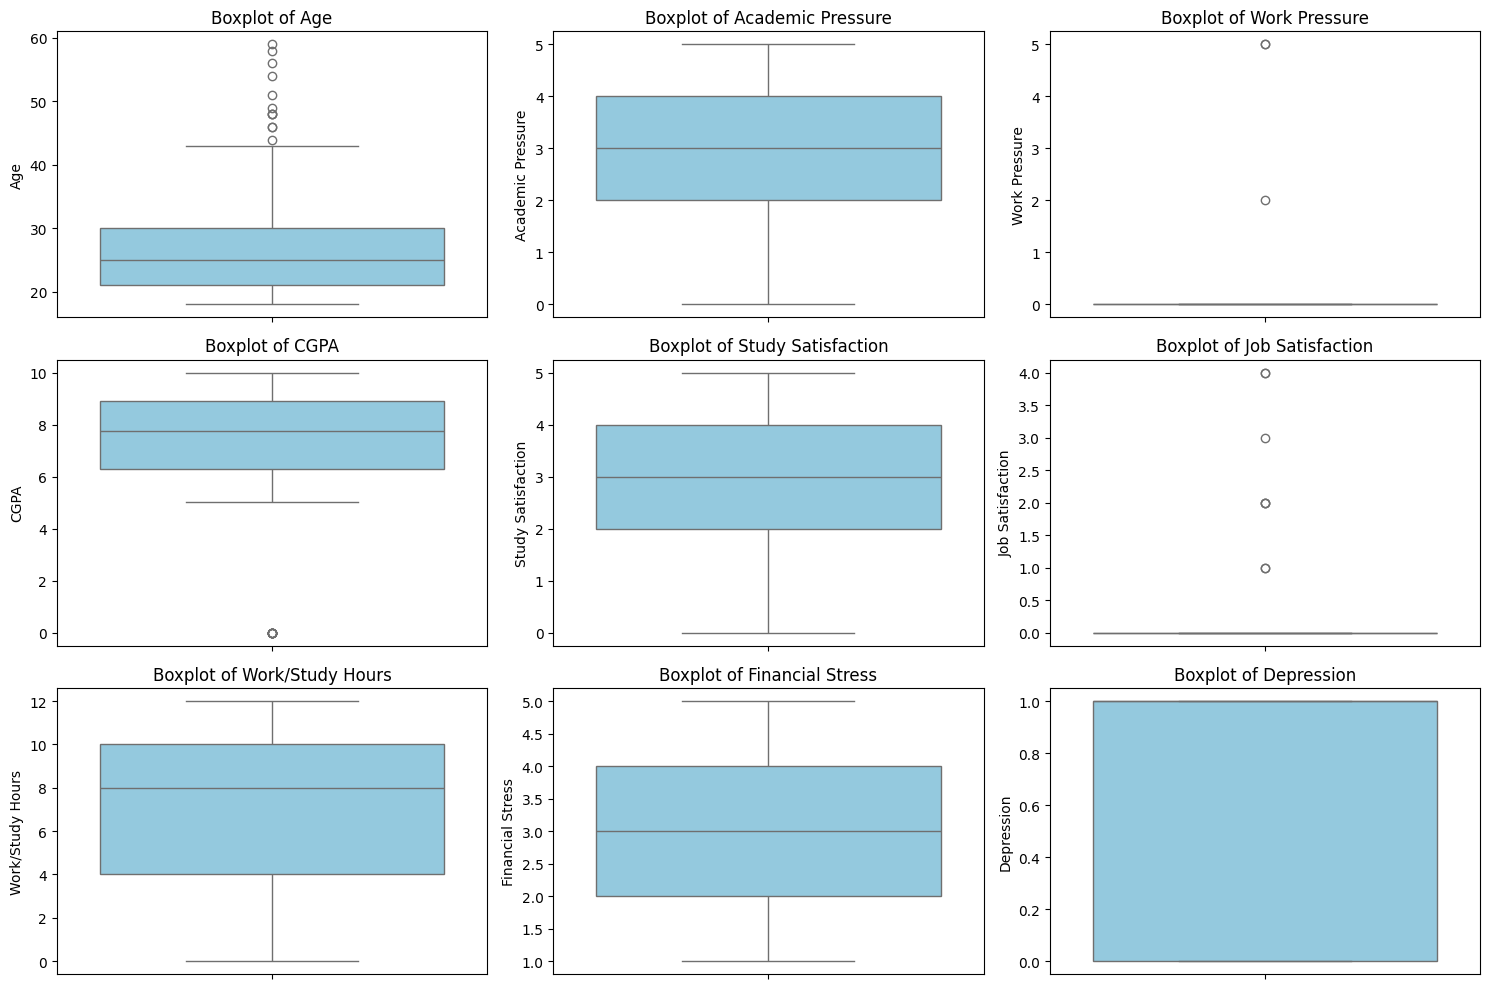

In [6]:
features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
                      'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

В Age много выбросов. Сбалансируем данные

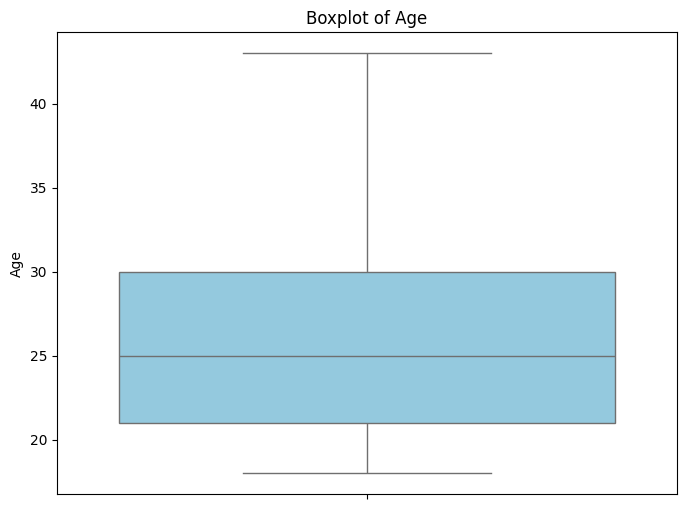

In [7]:
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5 * IQR
outliers = (df['Age'] < (Q1 - threshold)) | (df['Age'] > (Q3 + threshold))

median_rating = df['Age'].median()
df.loc[outliers, 'Age'] = median_rating

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Age'], color='skyblue')
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.show()

### Конструирование признаков с помощью меток

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['City'] = le.fit_transform(df['City'])
df['Dietary Habits'] = le.fit_transform(df['Dietary Habits'])
df['Degree'] = le.fit_transform(df['Degree'])
df['Have you ever had suicidal thoughts ?'] = le.fit_transform(df['Have you ever had suicidal thoughts ?'])
df['Sleep Duration'] = le.fit_transform(df['Sleep Duration'])
df['Profession'] = le.fit_transform(df['Profession'])
df['Study Satisfaction'] = le.fit_transform(df['Study Satisfaction'])
df['Family History of Mental Illness'] = le.fit_transform(df['Family History of Mental Illness'])

разделение на признаки и целевую переменную

In [9]:
x = df.drop('Depression', axis=1)
y = df['Depression']

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 1) Метод регрессии Лассо


In [15]:
from sklearn.linear_model import Lasso

param_grid_lasso = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
}

# Создание объекта GridSearchCV
grid_search_lasso = GridSearchCV(
    estimator=Lasso(),  
    param_grid=param_grid_lasso,  
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1 
)

grid_search_lasso.fit(x_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры для Lasso:")
print(grid_search_lasso.best_params_)

Лучшие гиперпараметры для Lasso:
{'alpha': 0.01, 'fit_intercept': False}


### 2) Метод градиентного бустинга

In [14]:

from sklearn.ensemble import GradientBoostingRegressor

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid_gb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_gb.fit(x_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры для Gradient Boosting:")
print(grid_search_gb.best_params_)

e:\AIM1.5\Scripts\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1215 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
978 fits failed with the following error:
Traceback (most recent call last):
  File "e:\AIM1.5\Scripts\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\AIM1.5\Scripts\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "e:\AIM1.5\Scripts\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "e:\AIM1.5\Scripts\Lib\site-packages\sklearn\utils\_param_validatio

Лучшие гиперпараметры для Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


### 3) Метод k-ближайших соседей

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_knn.fit(x_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры для k-Nearest Neighbors:")
print(grid_search_knn.best_params_)

Лучшие гиперпараметры для k-Nearest Neighbors:
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


### Предсказание на тестовой выборке

In [128]:
y_pred = model.predict(x_test)
y_pred_forest = model_forest.predict(x_test)
y_pred_lasso = model_lasso.predict(x_test)
y_pred_gb = model_gb.predict(x_test)
y_pred_neighbors = model_knn.predict(x_test)

### Оценка качества модели

1.	MSE  (Mean Squared Error)
Среднее значение квадратов разностей между предсказанными и фактическими значениями. Чем меньше значение, тем лучше модель.

In [156]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse1 = mean_squared_error(y_test, y_pred)
mse2 = mean_squared_error(y_test, y_pred_forest)
mse3 = mean_squared_error(y_test, y_pred_lasso)
mse4 = mean_squared_error(y_test, y_pred_gb)
mse5 = mean_squared_error(y_test, y_pred_neighbors)

mse1_rounded = round(mse1, 3)
mse2_rounded = round(mse2, 3)
mse3_rounded = round(mse3, 3)
mse4_rounded = round(mse4, 3)
mse5_rounded = round(mse5, 3)

print("Mean Squared Error (MSE):")
print(f"k-NN: \t\t\t{mse1_rounded}")
print(f"Random Forest: \t\t{mse2_rounded}")
print(f"Lasso: \t\t\t{mse3_rounded}")
print(f"Gradient Boosting: \t{mse4_rounded}")
print(f"k-Nearest Neighbors: \t{mse5_rounded}")

Mean Squared Error (MSE):
k-NN: 			0.213
Random Forest: 		0.118
Lasso: 			0.166
Gradient Boosting: 	0.113
k-Nearest Neighbors: 	0.326


2.	MAE
Среднее значение абсолютных разностей между предсказанными и фактическими значениями. Чем меньше значение, тем лучше модель.

In [155]:
from sklearn.metrics import mean_absolute_error

mae1 = round(mean_absolute_error(y_test, y_pred),3)
mae2 = round(mean_absolute_error(y_test, y_pred_forest),3)
mae3 = round(mean_absolute_error(y_test, y_pred_lasso),3)
mae4 = round(mean_absolute_error(y_test, y_pred_gb),3)
mae5 = round(mean_absolute_error(y_test, y_pred_neighbors),3)
print("Mean Absolute Error (MAE):")
print(f"k-NN: \t\t\t{mae1}")
print(f"Random Forest: \t\t{mae2}")
print(f"Lasso: \t\t\t{mae3}")
print(f"Gradient Boosting: \t{mae4}")
print(f"k-Nearest Neighbors: \t{mae5}")

Mean Absolute Error (MAE):
k-NN: 			0.213
Random Forest: 		0.238
Lasso: 			0.366
Gradient Boosting: 	0.246
k-Nearest Neighbors: 	0.485


3.	R-squared
Мера, показывающая, насколько хорошо модель объясняет изменчивость данных. Значение находится в диапазоне от 0 до 1, где 1 — идеальное соответствие, а 0 — модель не объясняет данные.

In [153]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² (R-squared): {r2}")

r2_1 = r2_score(y_test, y_pred)
r2_2 = r2_score(y_test, y_pred_forest)
r2_3 = r2_score(y_test, y_pred_lasso)
r2_4 = r2_score(y_test, y_pred_gb)
r2_5 = r2_score(y_test, y_pred_neighbors)

r2_1_rounded = round(r2_1, 3)
r2_2_rounded = round(r2_2, 3)
r2_3_rounded = round(r2_3, 3)
r2_4_rounded = round(r2_4, 3)
r2_5_rounded = round(r2_5, 3)

print("\nR² (R-squared):")
print(f"k-NN: \t\t\t{r2_1_rounded}")
print(f"Random Forest: \t\t{r2_2_rounded}")
print(f"Lasso: \t\t\t{r2_3_rounded}")
print(f"Gradient Boosting: \t{r2_4_rounded}")
print(f"k-Nearest Neighbors: \t{r2_5_rounded}")

R² (R-squared): 0.127933821917115

R² (R-squared):
k-NN: 			0.128
Random Forest: 		0.515
Lasso: 			0.319
Gradient Boosting: 	0.537
k-Nearest Neighbors: 	-0.337


4.	RMSE
 Среднее отклонение предсказаний от реальных данных. Чем меньше модуль, тем лучше модель.

In [151]:
rmse1 = np.sqrt(mse1)
rmse2 = np.sqrt(mse2)
rmse3 = np.sqrt(mse3)
rmse4 = np.sqrt(mse4)
rmse5 = np.sqrt(mse5)

rmse1_rounded = round(rmse1, 3)
rmse2_rounded = round(rmse2, 3)
rmse3_rounded = round(rmse3, 3)
rmse4_rounded = round(rmse4, 3)
rmse5_rounded = round(rmse5, 3)

print("Root Mean Squared Error (RMSE):")
print(f"k-NN: \t\t\t{rmse1_rounded}")
print(f"Random Forest: \t\t{rmse2_rounded}")
print(f"Lasso: \t\t\t{rmse3_rounded}")
print(f"Gradient Boosting: \t{rmse4_rounded}")
print(f"k-Nearest Neighbors: \t{rmse5_rounded}")

Root Mean Squared Error (RMSE):
k-NN: 			0.461
Random Forest: 		0.344
Lasso: 			0.407
Gradient Boosting: 	0.336
k-Nearest Neighbors: 	0.571


Лучший результат – градиентный бустинг и случайный лес.
Положительные результаты по всем критериям получил случайный лес. Три из четырех положительных результата у градиентного бустинга. 

Значит, случайный лес – наиболее точная и устойчивая стратегия обучения модели. Итоговая модель – model_forest.

Также, с помощью применение важности признаков (feature importance) на Случайном лесе, мы вывели основные факторы, вызывающие депрессию:

In [19]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(x_train, y_train)

feature_importances = model_rf.feature_importances_

import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                  Feature  Importance
13  Have you ever had suicidal thoughts ?    0.300542
5                       Academic Pressure    0.134276
0                                      id    0.087970
7                                    CGPA    0.079078
2                                     Age    0.066613
15                       Financial Stress    0.066330
3                                    City    0.059293
14                       Work/Study Hours    0.052275
12                                 Degree    0.049539
8                      Study Satisfaction    0.032944
11                         Dietary Habits    0.026140
10                         Sleep Duration    0.024435
16       Family History of Mental Illness    0.010547
1                                  Gender    0.009627
4                              Profession    0.000372
9                        Job Satisfaction    0.000017
6                           Work Pressure    0.000003
